In [19]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
market = Market()

In [21]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [22]:
start_date = datetime(2001,1,1)
end_date = datetime(2020,1,1)
lookbacks = [5,60]
holding_periods = [1,5,20]
floors = [-10,0]
ceilings = [1,10]
volatilities = [0.1,0.5,1]
positions = 20
tickers = sp500["ticker"]
asset = "stocks"
# positions = 1
# tickers = ["BTC"]
# asset = "crypto"

In [23]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors,volatilities)

In [24]:
len(parameters)

288

In [25]:
simulation = []
market.connect()
for ticker in tqdm(tickers):
    try:
        ticker_data = market.retrieve_ticker_prices(asset,ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data["week"] = [x.week for x in ticker_data["date"]]
        ticker_data["day"] = [x.weekday() for x in ticker_data["date"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
            ticker_data[f"rolling_stdev_{lookback}"] = ticker_data["prev_close"].rolling(lookback).std()
            ticker_data[f"rolling_pct_stdev_{lookback}"] = ticker_data[f"rolling_stdev_{lookback}"] / ticker_data[f"rolling_{lookback}"]
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:44<00:00, 10.89it/s]


In [26]:
final = pd.concat(simulation)

In [27]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [12:13<00:00,  2.55s/it]


In [28]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [29]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [01:00<00:00,  4.72it/s]


In [30]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility
200,2001-01-23,MSFT,-0.022784,0.928831,0,287,window,False,60,20,0,10,1.0
201,2001-01-23,WMB,-0.021436,1.061146,1,287,window,False,60,20,0,10,1.0
202,2001-01-23,DVN,-0.020930,1.006865,2,287,window,False,60,20,0,10,1.0
203,2001-01-23,AES,-0.018539,1.032920,3,287,window,False,60,20,0,10,1.0
204,2001-01-23,PFE,-0.018522,1.047552,4,287,window,False,60,20,0,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,2019-12-24,ORCL,-0.002662,1.016275,9,287,window,False,60,20,0,10,1.0
5030,2019-12-24,WM,-0.001418,1.074600,10,287,window,False,60,20,0,10,1.0
5031,2019-12-24,J,-0.001274,1.082952,11,287,window,False,60,20,0,10,1.0
5032,2019-12-24,HIG,-0.000969,0.982018,12,287,window,False,60,20,0,10,1.0


In [31]:
performance = pd.DataFrame(report)

In [32]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility
978,546.296251,59,rolling,True,60,5,-10,10,1.0
978,546.296251,68,rolling,True,60,5,0,10,1.0
4778,493.556353,164,window,True,5,1,-10,10,1.0
4778,471.417371,163,window,True,5,1,-10,10,0.5
978,455.948850,23,rolling,True,5,5,-10,10,1.0
978,454.376507,22,rolling,True,5,5,-10,10,0.5
4778,450.953079,56,rolling,True,60,1,-10,10,1.0
4778,450.953079,65,rolling,True,60,1,0,10,1.0
978,433.429442,5,rolling,True,5,5,-10,1,1.0
978,431.934758,4,rolling,True,5,5,-10,1,0.5


In [33]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [34]:
cumulative

position,date,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,pv
0,2001-01-02,1.113723,0.742000,1.105664,1.113339,1.194329,1.164812,0.996306,1.008353,0.964783,...,1.114626,1.183142,1.384102,0.565574,1.180115,1.540424,1.041013,1.283688,1.097561,1.091634
1,2001-01-09,1.234533,1.074082,1.295686,1.354998,1.264534,1.292683,1.094895,1.027598,1.231805,...,1.348866,1.210174,0.797394,1.122100,1.203376,1.845304,1.574903,1.144889,1.746087,1.392815
2,2001-01-16,0.959273,0.950498,1.047987,0.983435,1.002449,1.192122,1.107273,0.889767,1.276000,...,1.168239,0.985000,1.265440,1.049280,1.042278,1.111930,1.277778,0.914985,1.041459,1.485812
3,2001-01-23,0.987101,1.058441,0.920750,1.030323,1.106520,1.075901,0.955182,1.206560,0.978507,...,1.205436,1.153735,1.095277,0.999472,1.065070,0.991117,1.235362,1.244427,1.645714,1.629795
4,2001-01-30,1.010329,1.056511,0.992821,1.082353,0.834741,1.024645,0.884334,1.064857,1.023684,...,0.909253,0.834123,0.975361,0.940789,0.937143,1.155514,1.260191,0.890972,0.888036,1.600575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2019-12-03,0.999854,0.999137,0.989893,1.032447,1.007054,1.022156,0.992282,1.044288,1.009071,...,0.997216,1.022951,1.000781,0.975387,1.032069,1.138738,0.950270,1.125365,1.032713,517.686671
975,2019-12-10,1.053061,1.040879,1.003829,1.028048,1.017125,1.031284,1.026512,1.007250,0.980599,...,1.030883,1.058093,1.073579,0.996960,0.985177,1.035703,1.162470,1.005352,1.062701,533.834638
976,2019-12-17,1.003370,1.008783,1.122397,1.016652,1.007596,0.962946,1.033119,1.013501,1.025745,...,1.028342,1.045894,0.999697,1.022510,1.032687,1.018349,1.037631,1.012929,1.027584,545.639808
977,2019-12-24,1.001520,0.995130,1.010793,1.007434,0.998859,1.000961,1.007315,0.996929,1.026048,...,1.004753,1.005942,1.002627,1.011641,0.999371,1.020318,0.979745,0.996409,1.005899,547.422768


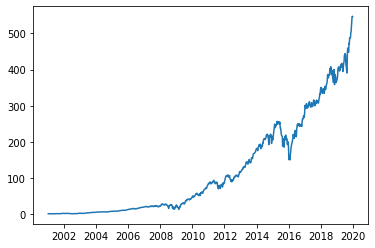

In [35]:
plt.plot(cumulative["date"],cumulative["pv"])

In [36]:
parameter

{'strategy': 'rolling',
 'value': True,
 'lookback': 60,
 'holding_period': 5,
 'floor': -10,
 'ceiling': 10,
 'volatility': 1}